# 1. Setup

## 1.1 Install Dependencies
Menginstall segala library yang dibutuh untuk Model Training ini

In [ ]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies
Mengimport segala library yang dibutuhkan

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Create Folder Structures
Struktur Folder Data

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors
Mengumpulkan data berupa gambar

## 2.1 Setup Face Detection for Better Collecting
Melakukan Face Detection untuk pengambilan gambar

In [4]:
frontalFaceCascade = cv2.CascadeClassifier("haarcascades/haarcascade_frontalface_default.xml")
profileFaceCascade = cv2.CascadeClassifier("haarcascades/haarcascade_profileface.xml")

In [5]:
def detectFace(grayscale, image):
    imageDet = image
    
    # Detects frontal faces in the image using the face cascade
    faces = frontalFaceCascade.detectMultiScale(
        grayscale,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30,30),
    )

    # Detects profile faces in the image using the face cascade
    profileFaces = profileFaceCascade.detectMultiScale(
        grayscale,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30,30),
    )

    # Detect profile faces in the flipped image to detect profile faces facing right
    flipped = cv2.flip(grayscale, 1)
    profileFacesFlipped = profileFaceCascade.detectMultiScale(
        flipped,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30,30),
    )

    if len(faces) != 0:
        for (x, y, w, h) in faces:
            imageDet = image[y:y+h, x:x+w]
    elif len(profileFaces) != 0:
        for (x, y, w, h) in profileFaces:
            imageDet = image[y:y+h, x:x+w]
    elif len(profileFacesFlipped) != 0:
        for (x, y, w, h) in profileFacesFlipped:
            imageDet = image[y:y+h, x:x+w]

    imageDet = cv2.resize(imageDet, (250, 250))

    return imageDet

## 2.2 Untar Labelled Faces in the Wild Dataset
Mengekstrak dataset dari sumber: http://vis-www.cs.umass.edu/lfw/

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
for file in os.listdir(NEG_PATH):
    image = cv2.imread(os.path.join(NEG_PATH, file))
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = detectFace(grayscale, image)
    cv2.imwrite(os.path.join(NEG_PATH, file), image)

## 2.3 Collect Positive and Anchor Classes
Mengumpulkan gambar Anchor dan Positive

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image = detectFace(grayscale, frame)

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, image)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, image)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

## 2.4 - Data Augmentation
Data Augmentasi

In [17]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [18]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images
Memuat dan memproses gambar

## 3.1 Get Image Directories
Direktori gambar

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(600)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(600)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(600)

## 3.2 Preprocessing - Scale and Resize
Mengubah ukuran gambar

In [20]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

## 3.3 Create Labelled Dataset
Membuat dataset yang mempunyai label

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

## 3.4 Build Train and Test Partition

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [26]:
inp = Input(shape=(100,100,3), name='input_image')

In [27]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [28]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [37]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [38]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [39]:
siamese_model = make_siamese_model()

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [44]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [46]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [47]:
EPOCHS = 50

In [48]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
53/53 [==============================] - 846s 16s/step
0.1312234 0.7152778 0.9967742

 Epoch 2/50
53/53 [==============================] - 838s 16s/step
0.020657152 0.96437055 0.98067635

 Epoch 3/50
53/53 [==============================] - 831s 16s/step
0.013409004 0.9601874 1.0

 Epoch 4/50
53/53 [==============================] - 826s 16s/step
0.05886902 0.9929078 0.9976247

 Epoch 5/50
53/53 [==============================] - 823s 16s/step
0.004686563 0.9904306 0.9951923

 Epoch 6/50
53/53 [==============================] - 823s 16s/step
0.06310718 1.0 1.0

 Epoch 7/50
53/53 [==============================] - 823s 16s/step
0.03764065 1.0 1.0

 Epoch 8/50
53/53 [==============================] - 824s 16s/step
0.00048278994 1.0 1.0

 Epoch 9/50
53/53 [==============================] - 822s 16s/step
0.00041458863 0.99765

# 6. Evaluate Model

## 6.1 Make Predictions

In [49]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [50]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [51]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

In [52]:
y_true

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

## 6.2 Calculate Metrics

In [53]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [54]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [55]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 589ms/step
1.0 1.0


## 6.3 Viz Results

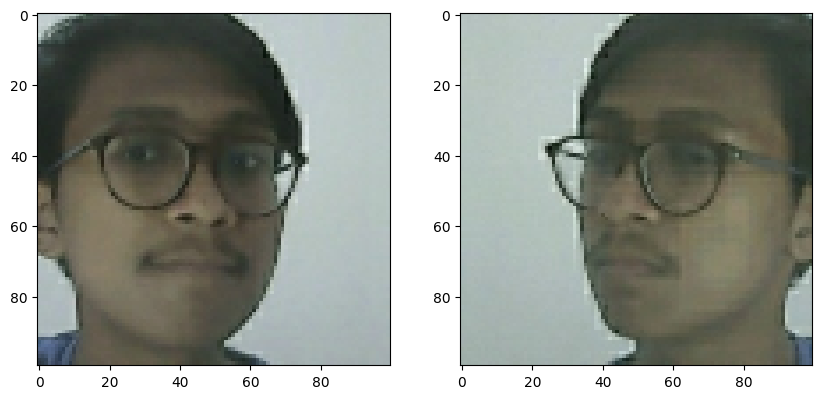

In [56]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [57]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [58]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [59]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 660ms/step


array([[1.0000000e+00],
       [1.6726578e-06],
       [2.1776876e-05],
       [1.0000000e+00],
       [9.9999130e-01],
       [1.0000000e+00],
       [9.9999779e-01],
       [3.9228518e-04]], dtype=float32)

In [60]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [61]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\34f2a31d-08ac-11ee-93e0-edd796e56f1c.jpg
application_data\verification_images\6e92c249-08ac-11ee-9474-edd796e56f1c.jpg
application_data\verification_images\6f2bb017-08ac-11ee-b6b3-edd796e56f1c.jpg
application_data\verification_images\70652c89-08ac-11ee-8005-edd796e56f1c.jpg
application_data\verification_images\70ad9192-08ac-11ee-bddb-edd796e56f1c.jpg
application_data\verification_images\71af3147-08ac-11ee-91c4-edd796e56f1c.jpg
application_data\verification_images\71d26b7b-08ac-11ee-a77e-edd796e56f1c.jpg
application_data\verification_images\738b833d-08ac-11ee-b5e3-edd796e56f1c.jpg
application_data\verification_images\7569d440-08ac-11ee-8132-edd796e56f1c.jpg
application_data\verification_images\75b5706f-08ac-11ee-9b2e-edd796e56f1c.jpg
application_data\verification_images\75d8cb5e-08ac-11ee-980b-edd796e56f1c.jpg
application_data\verification_images\770dd94b-08ac-11ee-ab18-edd796e56f1c.jpg
application_data\verification_images\77ce39a0-08ac-11ee-96c4-edd

In [63]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [67]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Verification', frame)

    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image = detectFace(grayscale, frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), image)
    # Run verification
        results, verified = verify(siamese_model, 0.67, 0.8)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 160ms/step
True
1/1 [==============================] - 0s 171ms/step
False
1/1 [==============================] - 0s 159ms/step
False
1/1 [==============================] - 0s 164ms/step
False
1/1 [==============================] - 0s 158ms/step
True
1/1 [==============================] - 0s 161ms/step
True
1/1 [==============================] - 0s 237ms/step
True
1/1 [==============================] - 0s 198ms/step
False


In [115]:
np.sum(np.squeeze(results) > 0.9)

0

In [116]:
results

[array([[0.00791668]], dtype=float32),
 array([[0.00161082]], dtype=float32),
 array([[3.3428274e-05]], dtype=float32),
 array([[0.00068569]], dtype=float32),
 array([[0.0016165]], dtype=float32),
 array([[0.00013279]], dtype=float32),
 array([[0.00121999]], dtype=float32),
 array([[2.5897052e-05]], dtype=float32),
 array([[0.00011021]], dtype=float32),
 array([[0.00367286]], dtype=float32),
 array([[0.49006423]], dtype=float32),
 array([[0.00168207]], dtype=float32),
 array([[0.57638377]], dtype=float32),
 array([[0.00632589]], dtype=float32),
 array([[0.00086024]], dtype=float32),
 array([[2.2787259e-05]], dtype=float32),
 array([[0.01155984]], dtype=float32),
 array([[0.00120713]], dtype=float32),
 array([[0.0091656]], dtype=float32),
 array([[0.00423287]], dtype=float32),
 array([[0.03395079]], dtype=float32),
 array([[0.74518186]], dtype=float32),
 array([[0.00063343]], dtype=float32),
 array([[4.5400986e-05]], dtype=float32),
 array([[0.4957359]], dtype=float32),
 array([[0.00563